# Lab Assignment 1: Cyber Data Analytics
### Ruben Groot Roessink & Christiaan van der Bogaard

This Jupyter Notebook is used to process credit card data from Adjen. It is part of the first lab assignment of the course Cyber Data Analytics of the 4TU Master Cyber Security of TU Delft and Univerity of Twente.

For questions you can email to Ruben Groot Roessink (r.grootroessink@student.utwente.nl) or Christiaan van der Bogaard (c.h.m.vanderbogaard@student.utwente.nl)

#### Imports + General data structuring

In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# from imblearn.over_sampling import SMOTE
sns.set()

In [19]:
# data inladen hier

# parse time with seconds to general date
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('data.csv', parse_dates=['bookingdate'], date_parser=dateparse)
data['bookingdate'] = data['bookingdate'].dt.date
# print(data.head())
data.drop(['bookingdate'], axis=1);
# remove refused entries
#data = data[data.simple_journal != 'Refused']

# distinguish datasets
data_benign = data[data.simple_journal == 'Settled']
data_fraud  = data[data.simple_journal == 'Chargeback']
data_refused = data[data.simple_journal == 'Refused']

print(data.columns)
data.head()

Index(['txid', 'bookingdate', 'issuercountrycode', 'txvariantcode', 'bin',
       'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
       'creationdate', 'accountcode', 'mail_id', 'ip_id', 'card_id'],
      dtype='object')


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


accountcode


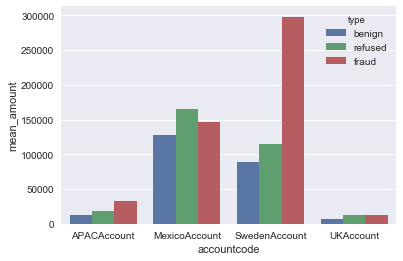

In [22]:
# generate column against mean of amount
def generate_bar_mean(data, col):
    data_mean = data[[col, 'amount']].groupby([col])['amount'].agg('mean').reset_index(name='mean_amount')
    return data_mean

['txid', 'bookingdate', 'issuercountrycode', 'txvariantcode', 'bin',
       'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
       'creationdate', 'accountcode', 'mail_id', 'ip_id', 'card_id'] 
x= 'accountcode'
data_mean_fraud = generate_bar_mean(data_fraud, x)
data_mean_benign = generate_bar_mean(data_benign, x)
data_mean_refused = generate_bar_mean(data_refused, x)
data_mean_fraud['type'] = 'fraud'
data_mean_benign['type']= 'benign'
data_mean_refused['type'] = 'refused'
data_mean = pd.concat([data_mean_benign, data_mean_refused, data_mean_fraud])
plot = sns.barplot(x=x, y="mean_amount", hue="type", data=data_mean)

figure = plot.get_figure()    
figure.savefig('barchart_'+x+'.png', dpi=800)

In [17]:
data = data[['issuercountrycode', 'txvariantcode',
       'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
        'accountcode']]
categorical = ['issuercountrycode', 'txvariantcode',
       'currencycode', 'shoppercountrycode', 'shopperinteraction',
        'cardverificationcodesupplied', 'cvcresponsecode',
        'accountcode']
data_with_dummies = pd.get_dummies(data, columns =  categorical)
training_features, test_features, training_target, test_target, = train_test_split(data_with_dummies.drop(['simple_journal'], axis=1),
                                               data_with_dummies['simple_journal'],
                                               test_size = .1,
                                               random_state=12)

clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(training_features, training_target)

res = clf_rf.predict(test_features)

pd.crosstab(res, test_target, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Chargeback,Settled,All
True,,,
Chargeback,1,20,21
Settled,27,23656,23683
All,28,23676,23704
